In [1]:
%pylab inline
import numpy as np
import pandas as pd

import seaborn as sns
sns.set_style('ticks')
sns.set_context('paper')
import sys

import Bio.PDB.PDBList as pdb

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
o = pd.read_csv('dali_known_state_hits.csv')
a = pd.read_csv('dali_alt_state_hits.csv')
a = a[a.columns[:7]]
o['Name'] = [x.replace('-','').upper() for x in o['Hit']]
a['Name'] = [x.replace('-','').upper() for x in a['Hit']]
o = o.drop_duplicates(subset='Hit')
a = a.drop_duplicates(subset='Hit')
o['frac_ali'] = [x/136 for x in o['lali']]
a['frac_ali'] = [x/136 for x in a['lali']]

o['wt_rmsd'] = o.apply(lambda row: row['rmsd']/row['frac_ali'], axis=1)
a['wt_rmsd'] = a.apply(lambda row: row['rmsd']/row['frac_ali'], axis=1)
o['Model'] = [x[:4] for x in o['Name']]
a['Model'] = [x[:4] for x in a['Name']]

o = o.sort_values('wt_rmsd')
a = a.sort_values('wt_rmsd')

print(len(o),len(a))

o_seqs = pd.read_csv('dali_known_state_seqs.csv')
a_seqs = pd.read_csv('dali_alt_state_seqs.csv')

o = o.merge(o_seqs,on='Name')
a = a.merge(a_seqs,on='Name')

print('n_unique_seqs')
print(len(o.Sequence.unique()), len(a.Sequence.unique()))

print('n_unique_models')
print(len(o.Model.unique()), len(a.Model.unique()))

2936 2645
n_unique_seqs
1820 1594
n_unique_models
1394 1245


In [3]:
# print('total data size')
# print(len(o),len(a))

o = o.merge(a, left_on=['Name','Sequence'],right_on=['Name','Sequence'], suffixes=('_o','_a'),how='outer')
o['zscore_diff'] = (o['Z-score_a']-o['Z-score_o'])/o['Z-score_o']
o['rmsd_diff'] = (o['wt_rmsd_a']-o['wt_rmsd_o'])/o['wt_rmsd_o']
print('Total entries')
print(len(o))
o['Model'] = [x[:4] for x in o['Name']]

# print('N unique models (not chains)')
# print(len(o['Model'].unique()))

o = o.sort_values('rmsd_diff',ascending=False)

print('N unique names among those models')
print(len(o['Name'].unique()))

print('N unique seqs among those models')
print(len(o['Sequence'].unique()))

o = o.drop_duplicates('Model')
o = o.drop_duplicates('Sequence')

print('final ds size:', len(o))

Total entries
3307
N unique names among those models
3265
N unique seqs among those models
2104
final ds size: 1508


In [4]:
def get_class(row):
    if not pd.isna(row['rmsd_diff']):
        if row['wt_rmsd_o']*1.05 < row['wt_rmsd_a'] and row['wt_rmsd_o'] < 4:
            return 'joint_o'
        elif row['wt_rmsd_o'] > row['wt_rmsd_a']*1.05 and row['wt_rmsd_a'] < 4:
            return 'joint_a'
        else:
            return 'joint_other'
    else:
        if not pd.isna(row['rmsd_o']):
            return 'o'
        elif not pd.isna(row['rmsd_a']):
            return 'a'
        
o['class'] = o.apply(lambda row: get_class(row), axis=1)

In [68]:
o.groupby('class')['wt_rmsd_o'].agg(['mean','std'])

,mean,std
class,,
a,NaN,NaN
joint,3.502088,1.178294
o,5.439449,1.256856


In [69]:
o.groupby('class')['wt_rmsd_a'].agg(['mean','std'])

,mean,std
class,,
a,5.323124,0.821747
joint,4.180875,0.728936
o,NaN,NaN


In [19]:
ctr=0
# write seqs for cdhit
with open('union_hits_refined_from_cdhit_11may2023.fasta','w') as f:
    for _, row in cdhit_filtered.iterrows():
        if not 'XXXXX' in row['Sequence']:
            if row['seq_len']<500 and (row['wt_rmsd_o']<5 or row['wt_rmsd_a']<5):
                f.write(">%s\n%s\n" % (row['Name'], row['Sequence']))
                ctr+=1
                
print(ctr)

499


In [18]:
ctr=0
with open('union_hits_refined_from_cdhit_11may2023_filter_len_only.fasta','w') as f:
    for _, row in cdhit_filtered.iterrows():
        if not 'XXXXX' in row['Sequence']:
            if row['seq_len']<500:
                f.write(">%s\n%s\n" % (row['Name'], row['Sequence']))
                ctr+=1
                
print(ctr)

972


In [6]:
cdhit_filtered = pd.read_csv('union_hits_cdhit_filter.csv')
cdhit_filtered = cdhit_filtered.merge(o, left_on=['Name','Sequence'], right_on=['Name','Sequence'])

In [7]:
len(cdhit_filtered)

1055

In [17]:
cdhit_filtered.loc[~pd.isna(cdhit_filtered.wt_rmsd_o)][~pd.isna(cdhit_filtered.wt_rmsd_a)]['wt_rmsd_o'].mean()

/var/folders/dz/yxswm4nd5gn8qr7s1_h0x71r0000gn/T/ipykernel_30183/4276099847.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  cdhit_filtered.loc[~pd.isna(cdhit_filtered.wt_rmsd_o)][~pd.isna(cdhit_filtered.wt_rmsd_a)]['wt_rmsd_o'].mean()


3.867792660360063

In [19]:
cdhit_filtered.loc[pd.isna(cdhit_filtered.wt_rmsd_a)]['wt_rmsd_o'].min()

2.1587301587301586

In [8]:
def tag_highlights(row):
    lst=['2EC4A','3EMXA','2L57A','6MZAA','3W8JB','3GL5A','4EUYA','3PH9B','2OKAA']
    near_1lu4a_lst=['3IOSA','3C71A','4NMUD','3OR5A','3GL3D','3KCMA','2LS5A','1KNGA','3U5RE','5UM7B']
    
    if row['Name'] == '1LU4A':
        return 'WT'
    elif row['Name'] in near_1lu4a_lst:
        return 'orig'
    elif row['Name'] in lst:
        return 'alt'
    else:
        return 'none'
    
cdhit_filtered['tag'] = cdhit_filtered.apply(lambda row: tag_highlights(row), axis=1)

Text(0, 0.5, 'weighted RMSD, new state')

posx and posy should be finite values
posx and posy should be finite values


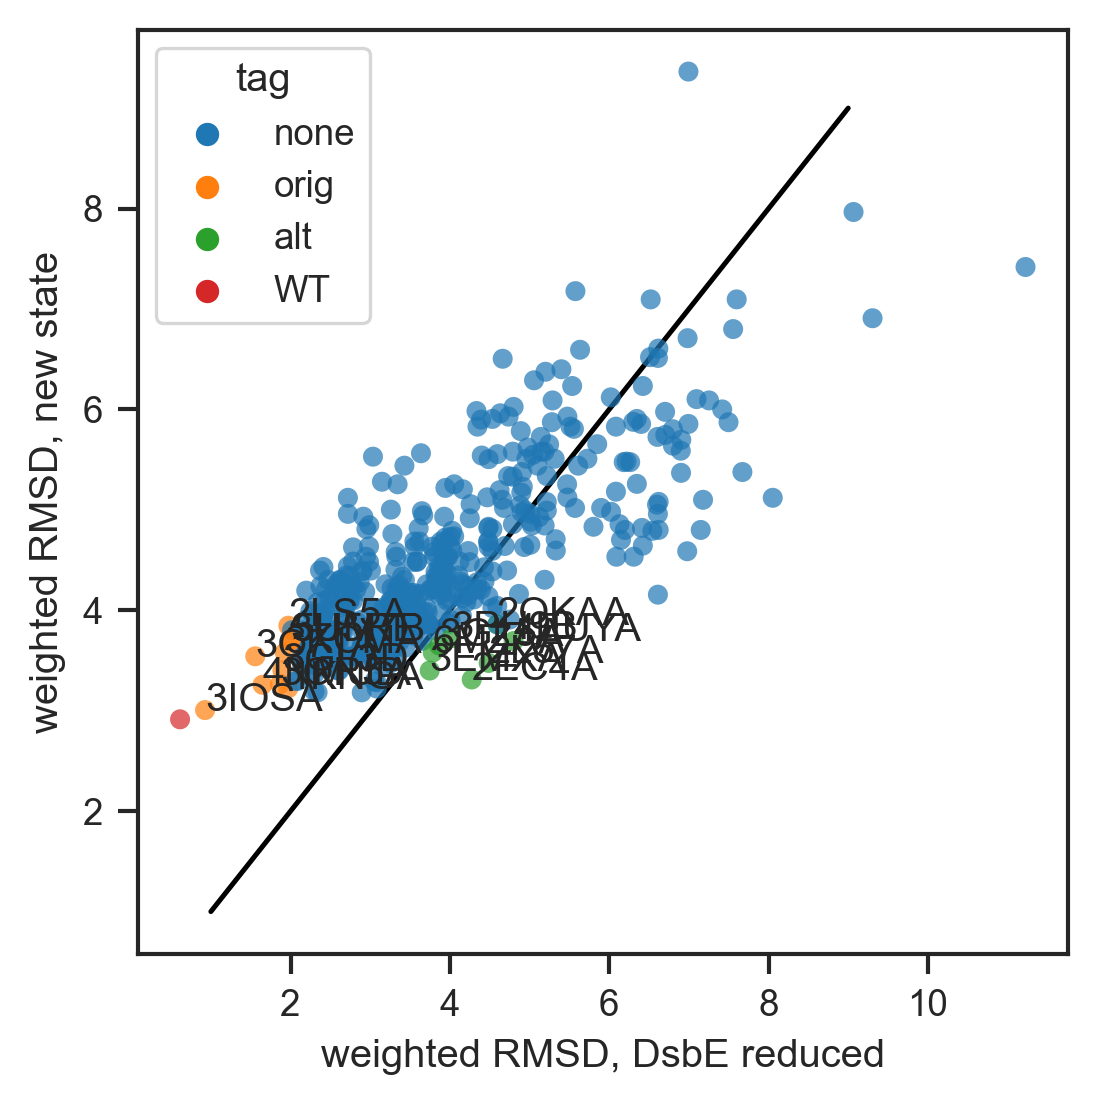

In [9]:
figure(figsize=(4,4))
sns.scatterplot(x='wt_rmsd_o',y='wt_rmsd_a',data=cdhit_filtered,linewidth=0,
                alpha=0.7,hue='tag', hue_order=['none','orig','alt','WT'])

for _, row in cdhit_filtered.sort_values('rmsd_diff').iterrows():
    
    if row['tag'] in ['alt','orig']:
         text(row['wt_rmsd_o'], row['wt_rmsd_a'],row['Name'])
        
# #     if row['wt_rmsd_o']>row['wt_rmsd_a']*1.05 and row['wt_rmsd_a'] < 4:
# #         print(row['Name'], row['wt_rmsd_a'])
#         #print(row['wt_rmsd_o'], row['wt_rmsd_a'], row['Name'])
        
#         text(row['wt_rmsd_o'], row['wt_rmsd_a'], row['Name'])
            
plot([1,9],[1,9],zorder=0, color='k')

xlabel('weighted RMSD, DsbE reduced')
ylabel('weighted RMSD, new state')
#savefig('may08_scatterplot_intersection.pdf',bbox_inches='tight')

<AxesSubplot:xlabel='wt_rmsd_a', ylabel='Count'>

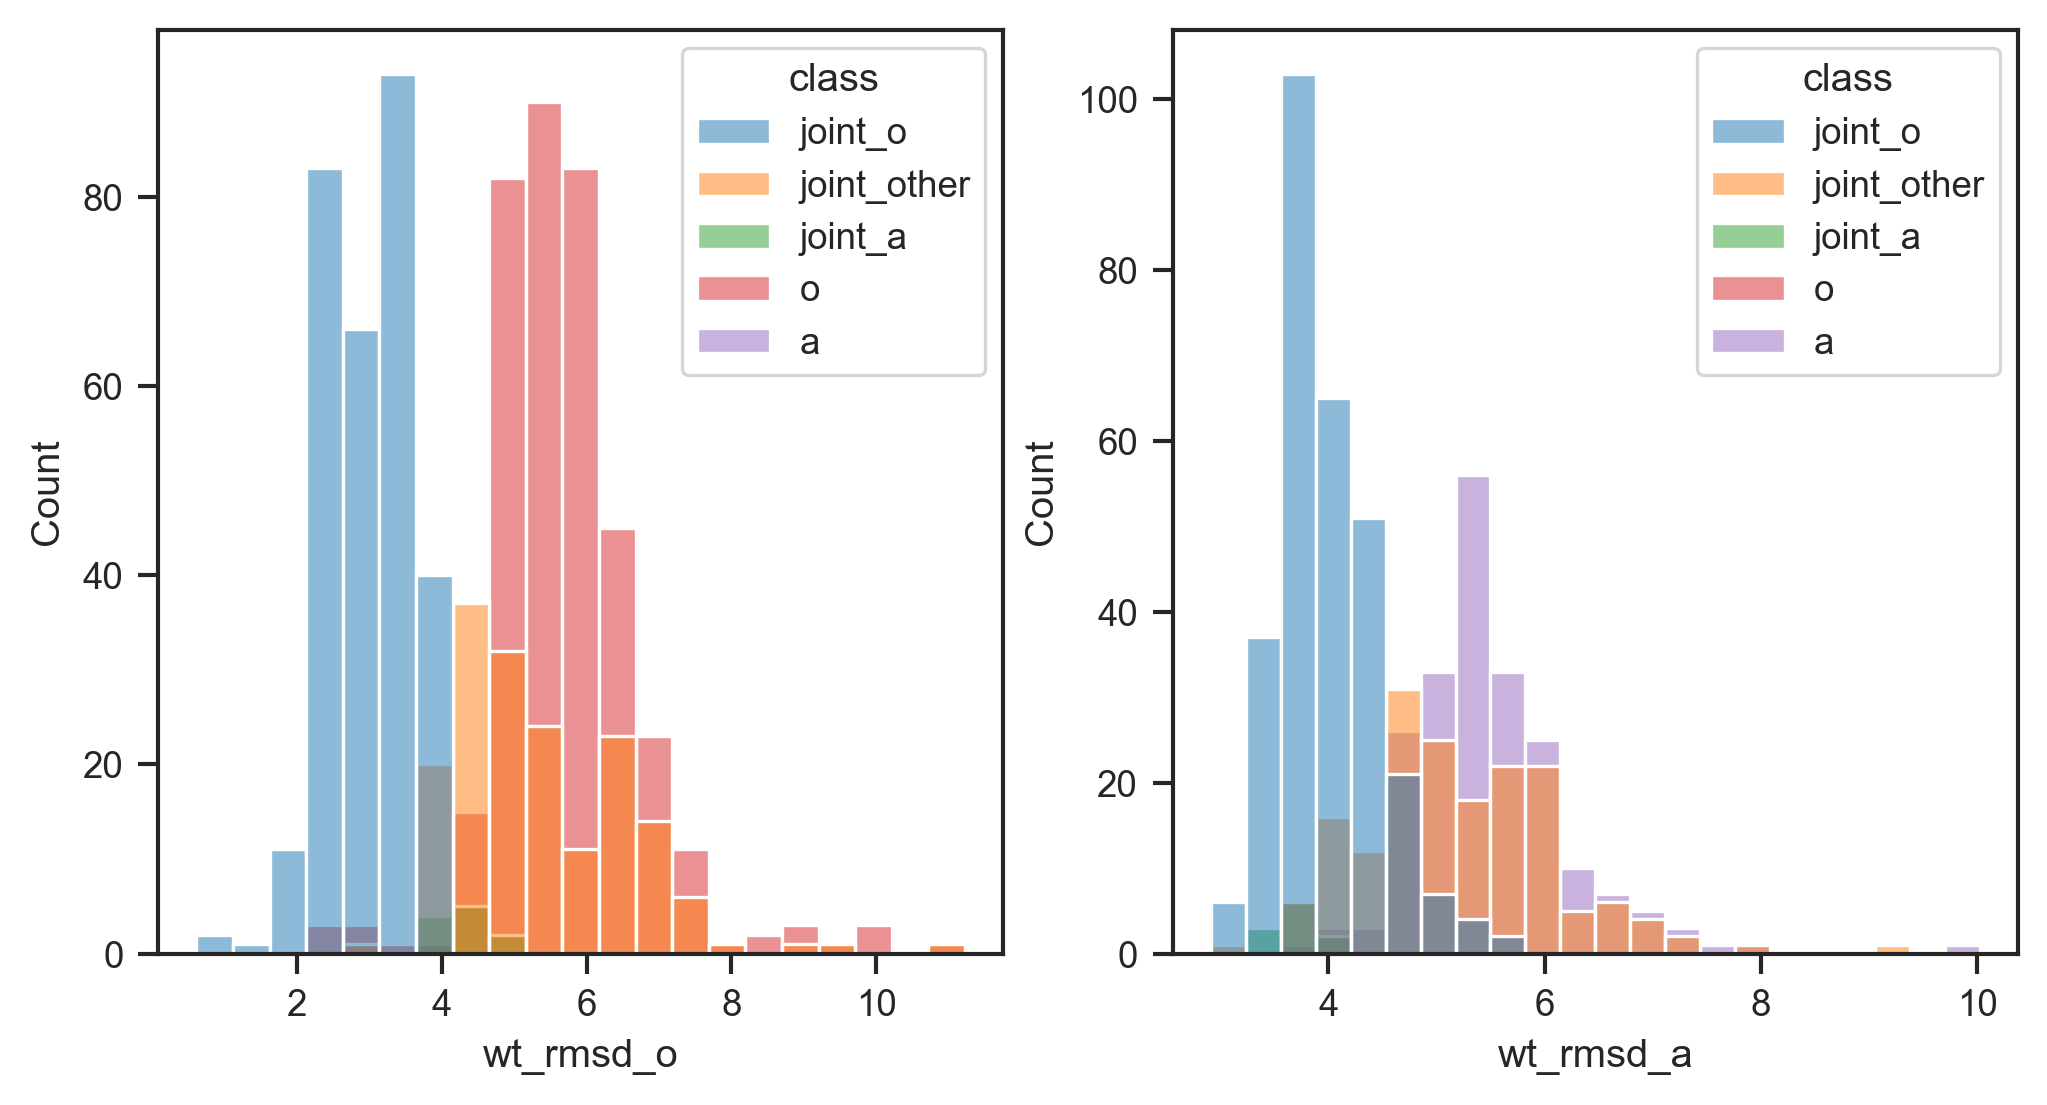

In [14]:
figure(figsize=(8,4))
subplot(1,2,1)
sns.histplot(x='wt_rmsd_o',data=cdhit_filtered,hue='class')
subplot(1,2,2)
sns.histplot(x='wt_rmsd_a',data=cdhit_filtered,hue='class')


In [128]:
for _, row in cdhit_filtered.loc[cdhit_filtered['class'].isin(['joint_a','a'])].sort_values('wt_rmsd_a').iterrows():
    print(row['Name'], row['class'],row['wt_rmsd_a'],row['rmsd_a'],)

2EC4A joint_a 3.311304347826087 2.8
3EMXA joint_a 3.4 2.5
2L57A joint_a 3.4755555555555553 2.3
6MZAA joint_a 3.5789473684210527 2.5
3W8JB a 3.6081632653061226 2.6
3GL5A joint_a 3.6487804878048786 2.2
4EUYA joint_a 3.6938271604938273 2.2
3PH9B joint_a 3.722105263157895 2.6
2OKAA joint_a 3.85945945945946 2.1
2OJLA joint_a 3.85945945945946 2.1
3D4TA joint_a 3.9080459770114944 2.5
2DBCA a 3.9257731958762885 2.8
5CAXB a 3.936842105263158 2.2
4F9ZB joint_a 3.9439999999999995 2.9
3DEXD a 4.098630136986301 2.2
3D8UB a 4.31219512195122 2.6
2LNSA a 4.327272727272727 2.8
2EK8A a 4.4818181818181815 2.9
4ONWA a 4.581052631578948 3.2
3IIBA a 4.584269662921348 3.0
5EREA a 4.586046511627907 2.9
1DP4C a 4.587951807228915 2.8
4GLTA a 4.594594594594595 2.5
5ABRA a 4.594594594594595 2.5
1YY7A a 4.5971830985915485 2.4
2HQBA a 4.648101265822785 2.7
2LJKA a 4.657534246575342 2.5
6ICAC a 4.675 3.3
3K9TA a 4.684444444444445 3.1
3I45A a 4.689655172413794 3.0
5A8JA a 4.6952380952380945 2.9
2X31A a 4.695238095238

In [8]:
for _, row in cdhit_filtered.sort_values('wt_rmsd_o')[:11].iterrows():
    print(row['Name'])
    #print(row['Sequence'])

1LU4A
3IOSA
3C71A
4NMUD
3OR5A
3GL3D
3KCMA
2LS5A
1KNGA
3U5RE
5UM7B
